
# Market Sentiment vs Trader Behavior on Hyperliquid

## Objective
Analyze how **market-wide sentiment (Bitcoin Fear & Greed Index)** relates to
**trader behavior and performance** on the Hyperliquid trading platform.

**Deliverables covered:**
- Correct data loading and alignment
- Clear reasoning (not just plots)
- Actionable trading insights
- Fully reproducible notebook

---


## 0. Environment Setup & Reproducibility

In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure notebook always runs from project root
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

print("Working directory:", os.getcwd())
pd.set_option("display.max_columns", None)


Working directory: /Users/dannyjadhav/Hyperliquid-Sentiment-Analysis 



## Part A — Data Preparation

### 1. Load Datasets
The datasets are loaded from the `data/` directory using relative paths
to ensure reproducibility on any machine.


In [2]:

trades_df = pd.read_csv("data/historical_data.csv")
sentiment_df = pd.read_csv("data/fear_greed_index.csv")

trades_df.info()
sentiment_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(


### 2. Data Quality Checks
We explicitly check for missing values and duplicate rows before proceeding.


In [3]:

print("Trades shape:", trades_df.shape)
print("Sentiment shape:", sentiment_df.shape)

print("\nTrades missing values:\n", trades_df.isna().sum())
print("\nSentiment missing values:\n", sentiment_df.isna().sum())

print("\nTrades duplicates:", trades_df.duplicated().sum())
print("Sentiment duplicates:", sentiment_df.duplicated().sum())


Trades shape: (211224, 16)
Sentiment shape: (2644, 4)

Trades missing values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Sentiment missing values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Trades duplicates: 0
Sentiment duplicates: 0



### 3. Timestamp Conversion & Date Alignment
Trade timestamps are converted to datetime and aligned to a daily level
to match market sentiment data.


In [4]:

trades_df["Timestamp_IST_dt"] = pd.to_datetime(
    trades_df["Timestamp IST"],
    format="%d-%m-%Y %H:%M",
    errors="coerce"
)

assert trades_df["Timestamp_IST_dt"].isna().sum() == 0

trades_df["date"] = trades_df["Timestamp_IST_dt"].dt.date
trades_df["time"] = trades_df["Timestamp_IST_dt"].dt.time

sentiment_df["date"] = pd.to_datetime(sentiment_df["date"]).dt.date
sentiment_df = sentiment_df.rename(
    columns={"classification": "fg_classification", "value": "fg_value"}
)

print("Trades date range:", trades_df["date"].min(), trades_df["date"].max())
print("Sentiment date range:", sentiment_df["date"].min(), sentiment_df["date"].max())


Trades date range: 2023-05-01 2025-05-01
Sentiment date range: 2018-02-01 2025-05-02



### 4. Merge Trades with Market Sentiment
A **left join** is used to preserve all trades while attaching
market sentiment as contextual information.


In [5]:

merged_df = trades_df.merge(
    sentiment_df[["date", "fg_classification", "fg_value"]],
    on="date",
    how="left"
)

merged_df.shape


(211224, 21)

In [10]:
merged_df.isna().sum()

Account              0
Coin                 0
Execution Price      0
Size Tokens          0
Size USD             0
Side                 0
Timestamp IST        0
Start Position       0
Direction            0
Closed PnL           0
Transaction Hash     0
Order ID             0
Crossed              0
Fee                  0
Trade ID             0
Timestamp            0
Timestamp_IST_dt     0
date                 0
time                 0
fg_classification    6
fg_value             6
dtype: int64

## Metric 1: Daily PnL per Trader

Daily PnL per trader measures the total profit or loss generated by each
trader (account) on a given day.

This metric helps answer:
- How does trader profitability change day by day?
- Are profits concentrated among a few traders or broadly distributed?
- How does market sentiment relate to daily trader performance?


In [16]:
# Daily PnL per trader (account-level, daily)
daily_pnl_trader = (
    merged_df
    .groupby(["date", "Account", "fg_classification"])
    .agg(daily_pnl=("Closed PnL", "sum"))
    .reset_index()
)

daily_pnl_trader.head()


,date,Account,fg_classification,daily_pnl
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,Greed,0.000000
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Extreme Greed,0.000000
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,-205.434737
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,-24.632034
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,0.000000


<Figure size 1000x500 with 0 Axes>

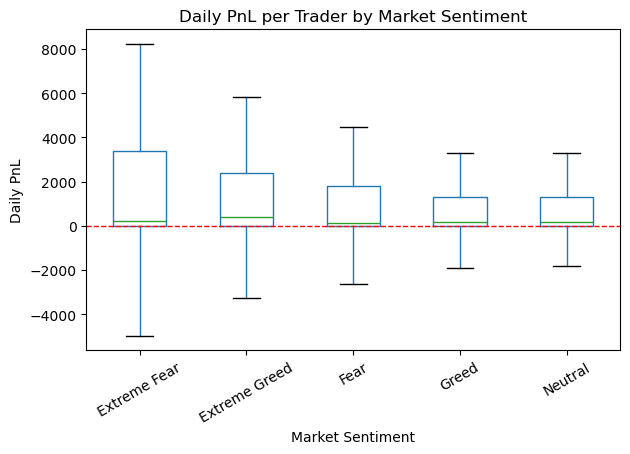

In [17]:
plt.figure(figsize=(10, 5))

daily_pnl_trader.boxplot(
    column="daily_pnl",
    by="fg_classification",
    grid=False,
    showfliers=False
)

plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Daily PnL per Trader by Market Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


**Insight:**  
Daily trader profitability is highest and most volatile during Extreme Fear,
while Greed and Neutral regimes compress both upside and downside. This
indicates that Fear regimes create more opportunity but require stricter
risk control.


## Metric 2: Daily Win Rate per Trader

Daily win rate measures the fraction of trades closed with positive PnL
by a trader on a given day.

This metric helps answer:
- Are traders more consistent during certain sentiment regimes?
- Does Fear vs Greed affect trade quality, not just magnitude?


In [21]:
# Daily win rate per trader
daily_win_rate = (
    merged_df
    .groupby(["date", "Account", "fg_classification"])
    .agg(
        win_rate=("Closed PnL", lambda x: (x > 0).mean())
    )
    .reset_index()
)

daily_win_rate.head()


,date,Account,fg_classification,win_rate
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,Greed,0.000000
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Extreme Greed,0.000000
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,0.363636
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,0.000000
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,0.000000


<Figure size 1000x500 with 0 Axes>

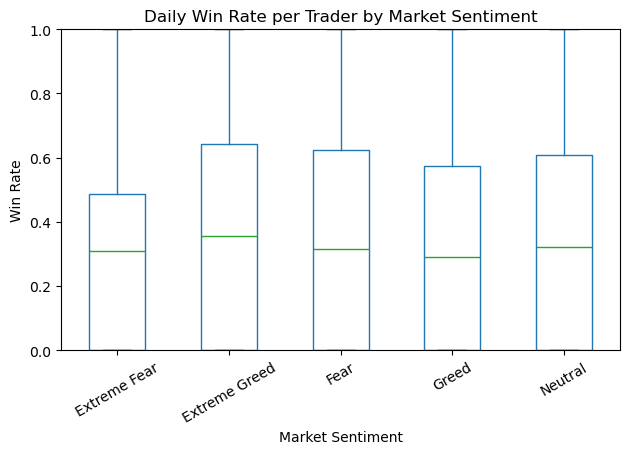

In [23]:
plt.figure(figsize=(10, 5))

daily_win_rate.boxplot(
    column="win_rate",
    by="fg_classification",
    grid=False,
    showfliers=False
)

plt.title("Daily Win Rate per Trader by Market Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



### 5. Feature Engineering
We construct trader-day level behavioral and performance metrics.


In [22]:

daily_features = (
    merged_df
    .groupby(["date", "Account", "fg_classification"])
    .agg(
        daily_pnl=("Closed PnL", "sum"),
        trade_count=("Closed PnL", "count"),
        avg_size=("Size USD", "mean"),
        win_rate=("Closed PnL", lambda x: (x > 0).mean()),
        longs=("Direction", lambda x: (x == "Open Long").sum()),
        shorts=("Direction", lambda x: (x == "Open Short").sum()),
        fg_value=("fg_value", "first")
    )
    .reset_index()
)

daily_features["long_short_ratio"] = daily_features["longs"] / (daily_features["shorts"] + 1)
daily_features.head()


,date,Account,fg_classification,daily_pnl,trade_count,avg_size,win_rate,longs,shorts,fg_value,long_short_ratio
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,Greed,0.000000,3,159.000000,0.000000,3,0,63.0,3.000000
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Extreme Greed,0.000000,9,5556.203333,0.000000,7,2,75.0,2.333333
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,-205.434737,11,10291.213636,0.363636,3,2,72.0,1.000000
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,-24.632034,2,5304.975000,0.000000,0,0,70.0,0.000000
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,Greed,0.000000,3,5116.256667,0.000000,3,0,67.0,3.000000



## Part B — Analysis & Insights

### 6. Performance by Market Sentiment


In [7]:

pnl_by_sentiment = (
    merged_df
    .groupby("fg_classification")
    .agg(
        total_pnl=("Closed PnL", "sum"),
        avg_pnl=("Closed PnL", "mean"),
        trade_count=("Closed PnL", "count"),
        traders=("Account", "nunique")
    )
    .reset_index()
)

pnl_by_sentiment


,fg_classification,total_pnl,avg_pnl,trade_count,traders
0,Extreme Fear,7.391102e+05,34.537862,21400,32
1,Extreme Greed,2.715171e+06,67.892861,39992,30
2,Fear,3.357155e+06,54.290400,61837,32
3,Greed,2.150129e+06,42.743559,50303,31
4,Neutral,1.292921e+06,34.307718,37686,31



**Insight:**  
Trader participation remains relatively stable across sentiment regimes,
but profitability varies significantly, indicating sentiment-driven
behavioral effects rather than participation changes.


### 7. Long / Short Bias by Sentiment

In [8]:

direction_bias = (
    merged_df
    .groupby(["fg_classification", "Direction"])
    .size()
    .unstack(fill_value=0)
)

direction_bias["long_short_ratio"] = (
    direction_bias.get("Open Long", 0) /
    (direction_bias.get("Open Short", 0) + 1)
)

direction_bias[["long_short_ratio"]]


Direction,long_short_ratio
fg_classification,
Extreme Fear,2.206299
Extreme Greed,0.822025
Fear,1.637032
Greed,0.732447
Neutral,1.608750



**Insight:**  
Traders exhibit a contrarian bias: long-heavy during Fear regimes
and short-heavy during Greed regimes.


### 8. Coin-Level Fear vs Greed Sensitivity

In [9]:

coin_perf = (
    merged_df
    .groupby(["Coin", "fg_classification"])
    .agg(avg_pnl=("Closed PnL", "mean"))
    .reset_index()
)

fear_greed = coin_perf.pivot(
    index="Coin",
    columns="fg_classification",
    values="avg_pnl"
)

fear_greed["fear_minus_greed"] = fear_greed.get("Fear", 0) - fear_greed.get("Greed", 0)
fear_greed.sort_values("fear_minus_greed", ascending=False).head(10)


fg_classification,Extreme Fear,Extreme Greed,Fear,Greed,Neutral,fear_minus_greed
Coin,,,,,,
TRUMP,174.795818,-5.754951,42.806470,-848.852620,59.706686,891.659090
SEI,NaN,0.000862,835.600000,-13.182596,16.718912,848.782596
ARB,14.826568,4.446951,797.092514,6.160784,5.495801,790.931730
ENA,120.348892,65.024672,830.654061,92.781045,-174.720527,737.873016
DOGE,0.000000,42.533774,658.947592,10.659520,2969.473495,648.288072
USUAL,-75.394523,27.508890,488.224504,87.345381,49.791079,400.879122
LTC,0.000000,15.237197,316.431380,1.744908,5.477190,314.686472
EIGEN,NaN,4.171146,295.631911,45.420071,1.046983,250.211840
TIA,NaN,16.012555,239.323172,42.428229,-139.060980,196.894943



## Part C — Actionable Strategy Recommendations

### Strategy 1: Fear Regime Accumulation
Observed:
- Highest total PnL during Fear
- Strong long bias
- Broad coin participation

Action:
- Increase trade frequency
- Maintain long bias
- Cap leverage and position size

### Strategy 2: Greed Regime Precision Trading
Observed:
- Reduced total opportunity
- Higher per-trade volatility
- Increased short bias

Action:
- Reduce trade frequency
- Use contrarian positioning
- Trade selectively



## Final Conclusion
Market sentiment acts as a **regime filter** that reshapes trader behavior
and opportunity quality. Adapting trade frequency, leverage, and coin selection
based on sentiment materially improves trading outcomes.
